In [125]:
%run SetUpParams.ipynb
%run IncludePyTrendsData.ipynb

[*********************100%%**********************]  1 of 1 completed

2024-08-18 00:12:03.589473
2004-08-18 00:12:03.589473



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\chuac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [126]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
import matplotlib.pyplot as plt

### Create dataframe for data exploration

In [127]:
explore_df = pd.DataFrame()
# Next Day Open Price - Current Day Open Price
explore_df[f'{target_stock}_change'] = target_stock_data['Open'].shift(-1) - target_stock_data['Open']
explore_df[f'{target_stock}_lag'] = explore_df[f'{target_stock}_change'].shift(1)
explore_df['Close'] = target_stock_data['Close']
explore_df['Price'] = target_stock_data['Open']
explore_df.reset_index(inplace=True)
# print(explore_df)

#### Add European and US Stock Market Price Changes to final_df
Current Day Open Price - Previous Day Open Price

In [128]:
# EU Stock Market has already opened
for ticker in US_EU_market_dict.keys():
        data = US_EU_market_dict[ticker]
        # Current Day Open Price - Previous Day Open Price
        temp = (data['Open'] - data['Open'].shift(1)).reset_index()
        temp.rename(columns={'Open':ticker}, inplace=True)
        explore_df = explore_df.merge(temp, on='Date', how='left')

#### Add Asian Stock Market Price Changes to final_df
Close Price - Open Price

In [129]:
# Asian Stock Market has already closed; one day ahead of US Stock Market
for ticker in asia_market_dict.keys():
        data = asia_market_dict[ticker]
        # Close Price - Open Price
        temp = (data['Close'] - data['Open']).reset_index()
        temp.rename(columns={0:ticker}, inplace=True)
        explore_df = explore_df.merge(temp, on='Date', how='left')

#### Merge explore_df with pytrends_data

In [130]:
explore_df['Month'] = explore_df['Date'].dt.month
explore_df['Year'] = explore_df['Date'].dt.year

explore_df = explore_df.merge(pytrends_data, on=['Month', 'Year'])
# Use previous day's relative difference of Bullish vs Bearish search term as independent variable
explore_df['Bullish_vs_Bearish_Diff'] = explore_df['Bullish_vs_Bearish_Diff'].shift(1)

In [131]:
# Different markets have different holidays
# Forward fill null values
explore_df.ffill(inplace=True)
explore_df.dropna(inplace=True, ignore_index=True)
# explore_df.isna().sum()

### Data Exploration

In [132]:
# Correlation matrix of f{target_stock}_change with all other variables
corr_target_lag = explore_df[f'{target_stock}_change'].corr(explore_df[f'{target_stock}_lag'])
print(corr_target_lag)
corr_ixic = explore_df[f'{target_stock}_change'].corr(explore_df['^IXIC'])
print(corr_ixic)
corr_dji = explore_df[f'{target_stock}_change'].corr(explore_df['^DJI'])
print(corr_dji)
corr_fchi = explore_df[f'{target_stock}_change'].corr(explore_df['^FCHI'])
print(corr_fchi)
corr_gdaxi = explore_df[f'{target_stock}_change'].corr(explore_df['^GDAXI'])
print(corr_gdaxi)
corr_aord = explore_df[f'{target_stock}_change'].corr(explore_df['^AORD'])
print(corr_aord)
corr_hsi = explore_df[f'{target_stock}_change'].corr(explore_df['^HSI'])
print(corr_hsi)
corr_n225 = explore_df[f'{target_stock}_change'].corr(explore_df['^N225'])
print(corr_n225)
corr_nsei = explore_df[f'{target_stock}_change'].corr(explore_df['^NSEI'])
print(corr_nsei)
corr_bull_vs_bear_diff = explore_df[f'{target_stock}_change'].corr(explore_df['Bullish_vs_Bearish_Diff'])
print(corr_bull_vs_bear_diff)

0.04409098905752986
0.10066872577989838
0.02178789987793788
0.05470458696236748
0.04691037456785035
0.10526080579230493
0.07172984309302194
0.12171406462016167
0.06394591563721144
0.042137180419646994


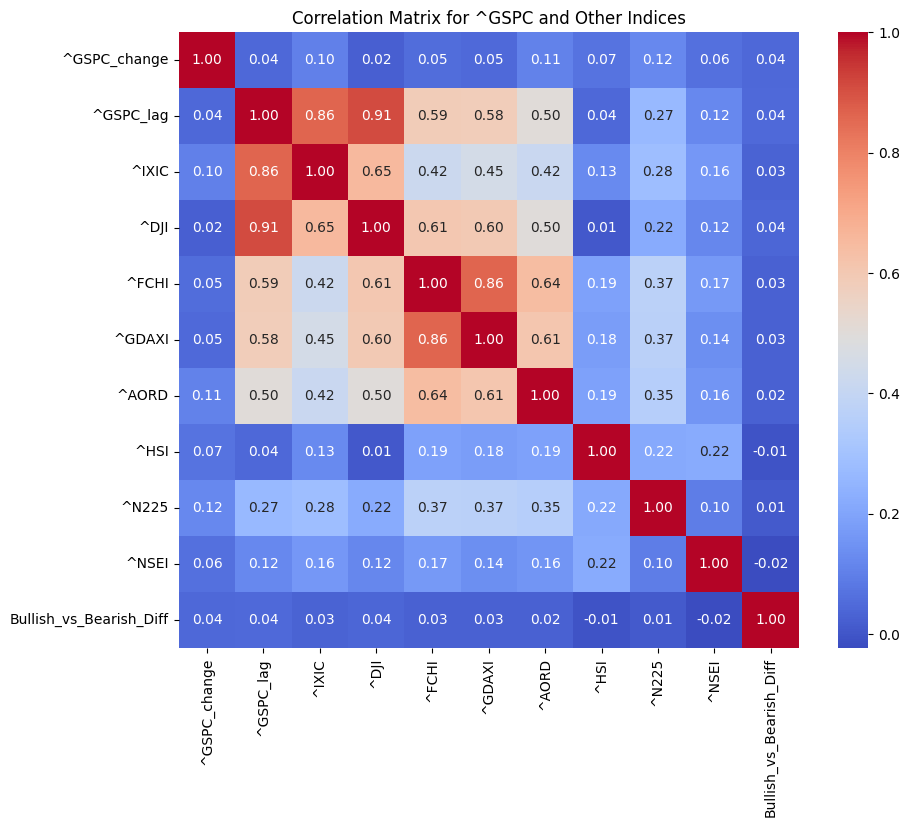

In [133]:
# Correlation matrix of all variables with each other
corr_df = explore_df.copy().drop(columns=['Date', 'Close', 'Price', 'Month', 'Year'])

corr_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Matrix for {target_stock} and Other Indices')
plt.show()

In [134]:
# Check proportion of stock price changes in the same/opposite direction for input markets
def get_direction_of_stock_change(series1, series2):
    same_direction = 0
    opposite_direction = 0
    total = 0 
    for i in range(len(series1)):
        if series1[i] > 0 and series2[i] > 0:
            same_direction += 1
        elif series1[i] < 0 and series2[i] < 0:
            same_direction += 1
        elif series1[i] < 0 and series2[i] > 0:
            opposite_direction += 1
        elif series1[i] > 0 and series2[i] < 0:
            opposite_direction += 1
        total += 1
    return same_direction / total * 100, opposite_direction / total * 100

In [135]:
proportion_of_direction_target_lag = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df[f'{target_stock}_lag'])
print(proportion_of_direction_target_lag)
proportion_of_direction_ixic = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^IXIC'])
print(proportion_of_direction_ixic)
proportion_of_direction_dji = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^DJI'])
print(proportion_of_direction_dji)
proportion_of_direction_fchi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^FCHI'])
print(proportion_of_direction_fchi)
proportion_of_direction_gdaxi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^GDAXI'])
print(proportion_of_direction_gdaxi)
proportion_of_direction_aord = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^AORD'])
print(proportion_of_direction_aord)
proportion_of_direction_hsi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^HSI'])
print(proportion_of_direction_hsi)
proportion_of_direction_n225 = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^N225'])
print(proportion_of_direction_n225)
proportion_of_direction_nsei = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^NSEI'])
print(proportion_of_direction_nsei)

(51.42052124911951, 48.5325193707443)
(54.87203568912891, 45.08100493073491)
(50.55177271660014, 49.40126790326368)
(51.42052124911951, 48.5559990608124)
(51.678797839868515, 48.274242779995305)
(52.876262033341156, 46.959380136182205)
(53.46325428504344, 46.46630664475229)
(54.23808405729045, 45.71495656257337)
(53.5571730453158, 46.395867574548014)


### Remove ^GSPC_lag, DJI, ^FCHI, ^GDAXI 

In [136]:
US_EU_list = ["^IXIC"]
US_EU_market_dict = {}

asia_list = ["^AORD", "^HSI", "^N225", "^NSEI"]
asia_market_dict = {}

for ticker in US_EU_list:
    data = yf.download(ticker, start, today)
    US_EU_market_dict[ticker] = data

for ticker in asia_list:
    data = yf.download(ticker, start, today)
    asia_market_dict[ticker] = data

final_df = pd.DataFrame()
# Next Day Open Price - Current Day Open Price
final_df[f'{target_stock}_change'] = target_stock_data['Open'].shift(-1) - target_stock_data['Open']
final_df[f'{target_stock}_lag'] = final_df[f'{target_stock}_change'].shift(1)
final_df['Close'] = target_stock_data['Close']
final_df['Price'] = target_stock_data['Open']
final_df.reset_index(inplace=True)

# EU Stock Market has already opened
for ticker in US_EU_market_dict.keys():
    data = US_EU_market_dict[ticker]
    # Current Day Open Price - Previous Day Open Price
    temp = (data['Open'] - data['Open'].shift(1)).reset_index()
    temp.rename(columns={'Open':ticker}, inplace=True)
    final_df = final_df.merge(temp, on='Date', how='left')

# Asian Stock Market has already closed; one day ahead of US Stock Market
for ticker in asia_market_dict.keys():
    data = asia_market_dict[ticker]
    # Close Price - Open Price
    temp = (data['Close'] - data['Open']).reset_index()
    temp.rename(columns={0:ticker}, inplace=True)
    final_df = final_df.merge(temp, on='Date', how='left')

# Merge with pytrends_data
final_df['Month'] = final_df['Date'].dt.month
final_df['Year'] = final_df['Date'].dt.year
final_df = final_df.merge(pytrends_data, on=['Month', 'Year'])
# Use previous day's relative difference of Bullish vs Bearish search term as independent variable
final_df['Bullish_vs_Bearish_Diff'] = final_df['Bullish_vs_Bearish_Diff'].shift(1)

final_df.ffill(inplace=True)
final_df.dropna(inplace=True, ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Prepare Sequences

In [137]:
input_df = final_df.copy().drop(columns=[f'{target_stock}_change', 'Date', 'Close', 'Price', 'Month', 'Year'])

In [138]:
# Train-Test Split
proportion_test = 0.8
gap = 60

output_df = final_df[f'{target_stock}_change'].to_frame()

train_index = round(len(input_df) * proportion_test)
test_index = train_index + gap

X_train = input_df.iloc[:train_index]
X_test = input_df.iloc[test_index:]

y_train = output_df.iloc[:train_index]
y_test = output_df.iloc[test_index:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3407, 7)
(792, 7)
(3407, 1)
(792, 1)


In [139]:
# Scaling inputs using Normalisation
scaler = StandardScaler()
X_scaled_train_temp = scaler.fit_transform(X_train)
X_scaled_train = pd.DataFrame(X_scaled_train_temp, columns = input_df.columns)

X_scaled_test_temp = scaler.fit_transform(X_test)
X_scaled_test = pd.DataFrame(X_scaled_test_temp, columns = input_df.columns)

In [140]:
def create_sequences(X_data, y_data, time_step = 10):
    X, y = [], []
    for i in range(len(X_data) - time_step):
        X.append(X_data.iloc[i:i + time_step, :].values)
        y.append(y_data.iloc[i+time_step, :].values)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

In [141]:
X_train_seq, y_train_seq = create_sequences(X_scaled_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_scaled_test, y_test)

In [142]:
# Shape of Tensor = (Number of Sequences, Time Steps, Number of Features)
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

torch.Size([3397, 10, 7])
torch.Size([3397, 1])
torch.Size([782, 10, 7])
torch.Size([782, 1])
